In [2]:
import sys
import math
import uproot
import operator
import numpy as np
import ROOT  as r
import sklearn.preprocessing
import matplotlib.pyplot as plt
from   scipy.optimize    import leastsq
from   scipy             import stats

Welcome to JupyROOT 6.22/00


In [3]:
def deltaphi(e_phi, m_phi) :
    d_phi =  e_phi - m_phi
    if (d_phi >  np.pi) : d_phi -= 2*np.pi
    if (d_phi < -np.pi) : d_phi += 2*np.pi
    return d_phi

In [4]:
def dR(e_phi, e_eta, m_phi, m_eta) :
    d_eta = abs(e_eta - m_eta)
    d_phi = deltaphi(e_phi, m_phi)
    return np.sqrt(d_phi**2 + d_eta**2)

In [5]:
def Convertnuto4vec(nu,i):
    neutrino = ROOT.TLorentzVector()
    Px = nu[0][i][0]
    Py = nu[0][i][1]
    Pz = nu[0][i][2]
    E  = math.sqrt(Px**2 + Py**2 + Pz**2)
    neutrino.SetPxPyPzE(Px,Py,Pz,E)
    return neutrino

In [6]:
mT = 172.5   # GeV : top quark mass
mW = 80.385  # GeV : W boson mass
mN = 0       # GeV : neutrino mass


def UnitCircle():
    '''Unit circle in extended representation'''
    return np.diag([1, 1, -1])


def cofactor(A, i, j):
    '''Cofactor[i,j] of 3x3 matrix A'''
    a = A[not i:2 if i==2 else None:2 if i==1 else 1,
          not j:2 if j==2 else None:2 if j==1 else 1]
    return (-1)**(i+j) * (a[0,0]*a[1,1] - a[1,0]*a[0,1])


def R(axis, angle):
    '''Rotation matrix about x(0),y(1), or z(2) axis'''
    c, s = math.cos(angle), math.sin(angle)
    R = c * np.eye(3)
    for i in [-1, 0, 1]:
        R[(axis-i) % 3, (axis+i) % 3] = i*s + (1 - i*i)
    return R


def Derivative():
    '''Matrix to differentiate [cos(t),sin(t),1]'''
    return R(2, math.pi / 2).dot(np.diag([1, 1, 0]))


def multisqrt(y):
    '''Valid real solutions to y=x*x'''
    return ([] if y < 0 else
            [0] if y == 0 else
            (lambda r: [-r, r])(math.sqrt(y)))


def factor_degenerate(G, zero=0):
    '''Linear factors of degenerate quadratic polynomial'''
    if G[0,0] == 0 == G[1,1]:
        return [[G[0,1], 0, G[1,2]],
                [0, G[0,1], G[0,2] - G[1,2]]]

    swapXY = abs(G[0,0]) > abs(G[1,1])
    Q = G[(1,0,2),][:,(1,0,2)] if swapXY else G
    Q /= Q[1,1]
    q22 = cofactor(Q, 2, 2)

    if -q22 <= zero:
        lines = [[Q[0,1], Q[1,1], Q[1,2]+s]
                 for s in multisqrt(-cofactor(Q, 0, 0))]
    else:
        x0, y0 = [cofactor(Q, i, 2) / q22 for i in [0, 1]]
        lines = [[m, Q[1,1], -Q[1,1]*y0 - m*x0]
                 for m in [Q[0,1] + s
                           for s in multisqrt(-q22)]]

    return [[L[swapXY],L[not swapXY],L[2]] for L in lines]


def intersections_ellipse_line(ellipse, line, zero=1e-12):
    '''Points of intersection between ellipse and line'''
    _,V = np.linalg.eig(np.cross(line,ellipse).T)
    sols = sorted([(v.real / v[2].real,
                    np.dot(line,v.real)**2 +
                    np.dot(v.real,ellipse).dot(v.real)**2)
                    for v in V.T],
                    key=lambda s: s[1])[:2]
    return [s for s, k in sols if k < zero]


def intersections_ellipses(A, B, returnLines=False):
    '''Points of intersection between two ellipses'''
    LA = np.linalg
    if abs(LA.det(B)) > abs(LA.det(A)): A,B = B,A
    e = next(e.real for e in LA.eigvals(LA.inv(A).dot(B))
             if not e.imag)
    lines = factor_degenerate(B - e*A)
    points = sum([intersections_ellipse_line(A,L)
                  for L in lines],[])
    return (points,lines) if returnLines else points


class nuSolutionSet(object):
    '''Definitions for nu analytic solution, t->b,mu,nu'''

    def __init__(self, b, mu, mW2=mW**2, mT2=mT**2, mN2=mN**2):
        
        c = r.Math.VectorUtil.CosTheta(b,mu)
        s = math.sqrt(1-c**2)

        x0p = - (mT2 - mW2 - b.M2()) / (2*b.E())
        x0  = - (mW2 - mu.M2() - mN2) / (2*mu.E())

        Bb, Bm = b.Beta(), mu.Beta()

        Sx = (x0 * Bm - mu.P()*(1-Bm**2)) / Bm**2
        Sy = (x0p / Bb - c * Sx) / s

        w  = (Bm / Bb - c) / s
        w_ = (-Bm / Bb - c) / s

        Om2  = w**2 + 1 - Bm**2
        eps2 = (mW2 - mN2) * (1 - Bm**2)
        x1   = Sx - (Sx+w*Sy) / Om2
        y1   = Sy - (Sx+w*Sy) * w / Om2
        Z2   = x1**2 * Om2 - (Sy-w*Sx)**2 - (mW2-x0**2-eps2)
        Z    = math.sqrt(max(0, Z2))

        for item in ['b','mu','c','s','x0','x0p',
                     'Sx','Sy','w','w_','x1','y1',
                     'Z','Om2','eps2','mW2']:
            setattr(self, item, eval(item))

    @property
    def K(self):
        '''Extended rotation from F' to F coord.'''
        return np.array([[self.c, -self.s, 0, 0],
                         [self.s,  self.c, 0, 0],
                         [     0,       0, 1, 0],
                         [     0,       0, 0, 1]])

    @property
    def A_mu(self):
        '''F coord. constraint on W momentum: ellipsoid'''
        B2   = self.mu.Beta()**2
        SxB2 = self.Sx * B2
        F    = self.mW2 - self.x0**2 - self.eps2
        return np.array([[1-B2, 0, 0, SxB2],
                         [   0, 1, 0,    0],
                         [   0, 0, 1,    0],
                         [SxB2, 0, 0,    F]])

    @property
    def A_b(self):
        '''F coord. constraint on W momentum: ellipsoid'''
        K, B = self.K, self.b.Beta()
        mW2, x0p = self.mW2, self.x0p
        A_b_ = np.array([[1-B*B,  0,  0,      B*x0p],
                         [    0,  1,  0,          0],
                         [    0,  0,  1,          0],
                         [B*x0p,  0,  0, mW2-x0p**2]])
        return K.dot(A_b_).dot(K.T)

    @property
    def R_T(self):
        '''Rotation from F coord. to laboratory coord.'''
        b_xyz = self.b.X(), self.b.Y(), self.b.Z()
        R_z   = R(2, -self.mu.Phi())
        R_y   = R(1, 0.5*math.pi - self.mu.Theta())
        R_x   = next(R(0,-math.atan2(z,y))
                   for x,y,z in (R_y.dot(R_z.dot(b_xyz)),))
        return R_z.T.dot(R_y.T.dot(R_x.T))

    @property
    def H_tilde(self):
        '''Transformation of t=[c,s,1] to p_nu: F coord.'''
        x1, y1, p = self.x1, self.y1, self.mu.P()
        Z, w, Om  = self.Z , self.w , math.sqrt(self.Om2)
        return np.array([[  Z/Om, 0, x1-p],
                         [w*Z/Om, 0,   y1],
                         [     0, Z,    0]])

    @property
    def H(self):
        '''Transformation of t=[c,s,1] to p_nu: lab coord.'''
        return self.R_T.dot(self.H_tilde)

    @property
    def H_perp(self):
        '''Transformation of t=[c,s,1] to pT_nu: lab coord.'''
        return np.vstack([self.H[:2], [0, 0, 1]])

    @property
    def N(self):
        '''Solution ellipse of pT_nu: lab coord.'''
        HpInv = np.linalg.inv(self.H_perp)
        return HpInv.T.dot(UnitCircle()).dot(HpInv)


class doubleNeutrinoSolutions(object):
    '''Solution pairs of neutrino momenta, tt -> leptons'''
    def __init__(self, b, b_ , mu, mu_, metX, metY, mW2=mW**2, mT2=mT**2):
        
        self.solutionSets = [nuSolutionSet(B, M, mW2, mT2)
                             for B,M in zip((b,b_),(mu,mu_))]

        V0     = np.outer([metX, metY, 0], [0, 0, 1])
        self.S = V0 - UnitCircle()

        N, N_ = [ss.N for ss in self.solutionSets]
        n_    = self.S.T.dot(N_).dot(self.S)

        v  = intersections_ellipses(N, n_)
        v_ = [self.S.dot(sol) for sol in v]

        if not v and leastsq:
            es  = [ss.H_perp for ss in self.solutionSets]
            met = np.array([metX, metY, 1])

            def nus(ts):
                return tuple(e.dot([math.cos(t), math.sin(t), 1])
                             for e, t in zip(es, ts))

            def residuals(params):
                return sum(nus(params), -met)[:2]

            ts,_  = leastsq(residuals, [0, 0], ftol=5e-5, epsfcn=0.01)
            v, v_ = [[i] for i in nus(ts)]
      
        for k, v in {'perp': v, 'perp_': v_, 'n_': n_}.items():
            setattr(self, k, v)

    @property
    def nunu_s(self):
        '''Solution pairs for neutrino momenta'''
        K, K_ = [ss.H.dot(np.linalg.inv(ss.H_perp))
                 for ss in self.solutionSets]
        return [(K.dot(s), K_.dot(s_))
                for s, s_ in zip(self.perp, self.perp_)]

In [7]:
def Convertnuto4vec_new(nu):
    nu_arr = []
    # Solution number, nuetrino number, Px/y/z
    for i in range(len(nu)):
        for j in range(2): 
            neutrino = ROOT.TLorentzVector()
            Px = nu[i][j][0]
            Py = nu[i][j][1]
            Pz = nu[i][j][2]
            E  = math.sqrt(Px**2 + Py**2 + Pz**2)
            neutrino.SetPxPyPzE(Px,Py,Pz,E)
            nu_arr.append(neutrino)
    return nu_arr

In [8]:
tt_ptr        = uproot.open('ttbar_final.root')['Step8']

tt_ST         = tt_ptr['ST'].array()
tt_HT         = tt_ptr['HT'].array()
tt_MET        = tt_ptr['MET'].array()
tt_MET_phi    = tt_ptr['MET_phi'].array()

tt_l_pt       = tt_ptr['l_pt'].array()
tt_l_eta      = tt_ptr['l_eta'].array()
tt_l_phi      = tt_ptr['l_phi'].array()
tt_l_mass     = tt_ptr['l_mass'].array()

tt_sl_pt      = tt_ptr['sl_pt'].array()
tt_sl_eta     = tt_ptr['sl_eta'].array()
tt_sl_phi     = tt_ptr['sl_phi'].array()
tt_sl_mass    = tt_ptr['sl_mass'].array()

tt_ljet_pt    = tt_ptr['ljet_pt'].array()
tt_ljet_eta   = tt_ptr['ljet_eta'].array()
tt_ljet_phi   = tt_ptr['ljet_phi'].array()

tt_sljet_pt   = tt_ptr['sljet_pt'].array()
tt_sljet_eta  = tt_ptr['sljet_eta'].array()
tt_sljet_phi  = tt_ptr['sljet_phi'].array()

## EXACT ONLY NO SMEARING 

In [29]:
import ROOT

no_sol    = 0

tt_mass   = []

top_pt    = []
top_eta   = []
top_phi   = []

lep_pt    = []
lep_eta   = []
lep_phi   = []
lep_mass  = []

atop_pt   = []
atop_eta  = []
atop_phi  = []

alep_pt   = []
alep_eta  = []
alep_phi  = []
alep_mass = []

selection = np.zeros(10000)

for i in range (10000) :
    first_pair = 0
    sec_pair   = 0
    
    jet1 = ROOT.TLorentzVector()
    jet2 = ROOT.TLorentzVector()
    lep1 = ROOT.TLorentzVector()
    lep2 = ROOT.TLorentzVector()
    
    top1 = ROOT.TLorentzVector()
    top2 = ROOT.TLorentzVector()
    
    atop1 = ROOT.TLorentzVector()
    atop2 = ROOT.TLorentzVector()
    
    jet1.SetPtEtaPhiM(tt_ljet_pt[i] , tt_ljet_eta[i] , tt_ljet_phi[i] , 4.2)
    jet2.SetPtEtaPhiM(tt_sljet_pt[i], tt_sljet_eta[i], tt_sljet_phi[i], 4.2)
    
    lep1.SetPtEtaPhiM(tt_l_pt[i] , tt_l_eta[i] , tt_l_phi[i] , tt_l_mass[i])
    lep2.SetPtEtaPhiM(tt_sl_pt[i], tt_sl_eta[i], tt_sl_phi[i], tt_sl_mass[i])
    
    met_x   =  tt_MET[i] * np.cos(tt_MET_phi[i])
    met_y   =  tt_MET[i] * np.sin(tt_MET_phi[i])
    
    #Maybe see if a solution exists or not
    try    :
        d  = doubleNeutrinoSolutions(jet1, jet2, lep1, lep2, met_x, met_y)
        first_pair  += 1
        
    except np.linalg.LinAlgError : pass
        
    # If not the first pairing, then the other one
    try :
        d_alt = doubleNeutrinoSolutions(jet1, jet2, lep2, lep1, met_x, met_y)
        sec_pair += 1
        
    except np.linalg.LinAlgError: pass
    
    if (first_pair == 1 and sec_pair == 0) :
        neutrino1  = Convertnuto4vec(d.nunu_s,0)
        neutrino2  = Convertnuto4vec(d.nunu_s,1)
        top1       = jet1 + lep1 + neutrino1
        top2       = jet2 + lep2 + neutrino2
        
        top_pt.append(top1.Pt())
        top_eta.append(top1.Eta())
        top_phi.append(top1.Phi())
        
        atop_pt.append(top2.Pt())
        atop_eta.append(top2.Eta())
        atop_phi.append(top2.Phi())
        
        lep_pt.append(lep1.Pt())
        lep_eta.append(lep1.Eta())
        lep_phi.append(lep1.Phi())
        lep_mass.append(lep1.M())
        
        alep_pt.append(lep2.Pt())
        alep_eta.append(lep2.Eta())
        alep_phi.append(lep2.Phi())
        alep_mass.append(lep2.M())
        
        tt_mass.append((top1   + top2).M())
        selection[i] = 1
        
    elif(sec_pair == 1  and first_pair == 0) :
        neutrino1  = Convertnuto4vec(d_alt.nunu_s,0)
        neutrino2  = Convertnuto4vec(d_alt.nunu_s,1)
        top1       = jet1 + lep2 + neutrino1
        top2       = jet2 + lep1 + neutrino2
        
        top_pt.append(top1.Pt())
        top_eta.append(top1.Eta())
        top_phi.append(top1.Phi())
        
        atop_pt.append(top2.Pt())
        atop_eta.append(top2.Eta())
        atop_phi.append(top2.Phi())
        
        lep_pt.append(lep2.Pt())
        lep_eta.append(lep2.Eta())
        lep_phi.append(lep2.Phi())
        lep_mass.append(lep2.M())
        
        alep_pt.append(lep1.Pt())
        alep_eta.append(lep1.Eta())
        alep_phi.append(lep1.Phi())
        alep_mass.append(lep1.M())
        
        tt_mass.append((top1   + top2).M())
        selection[i] = 1
        
    elif(first_pair == 1 and sec_pair == 1) :
        dr1 = dR(jet1.Phi(), jet1.Eta(), lep1.Phi(), lep1.Eta()) + dR(jet2.Phi(), jet2.Eta(), lep2.Phi(), lep2.Eta())
        dr2 = dR(jet1.Phi(), jet1.Eta(), lep2.Phi(), lep2.Eta()) + dR(jet2.Phi(), jet2.Eta(), lep1.Phi(), lep1.Eta())
        
        if (dr1 < dr2) :
            neutrino1  = Convertnuto4vec(d.nunu_s,0)
            neutrino2  = Convertnuto4vec(d.nunu_s,1)

            top1 = jet1 + lep1 + neutrino1
            top2 = jet2 + lep2 + neutrino2
            
            lep_pt.append(lep1.Pt())
            lep_eta.append(lep1.Eta())
            lep_phi.append(lep1.Phi())
            lep_mass.append(lep1.M())

            alep_pt.append(lep2.Pt())
            alep_eta.append(lep2.Eta())
            alep_phi.append(lep2.Phi())
            alep_mass.append(lep2.M())

        else:
            neutrino1  = Convertnuto4vec(d_alt.nunu_s,0)
            neutrino2  = Convertnuto4vec(d_alt.nunu_s,1)
            
            top1 = jet1 + lep2 + neutrino1
            top2 = jet2 + lep1 + neutrino2
            
            lep_pt.append(lep2.Pt())
            lep_eta.append(lep2.Eta())
            lep_phi.append(lep2.Phi())
            lep_mass.append(lep2.M())

            alep_pt.append(lep1.Pt())
            alep_eta.append(lep1.Eta())
            alep_phi.append(lep1.Phi())
            alep_mass.append(lep1.M())
        
        top_pt.append(top1.Pt())
        top_eta.append(top1.Eta())
        top_phi.append(top1.Phi())
        
        atop_pt.append(top2.Pt())
        atop_eta.append(top2.Eta())
        atop_phi.append(top2.Phi())
        
        tt_mass.append((top1   + top2).M())
        selection[i] = 1
        
    if (first_pair == 0 and sec_pair == 0) : 
        no_sol += 1

<ipython-input-6-d2c98e6ea2ab>:59: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return [[L[swapXY],L[not swapXY],L[2]] for L in lines]
/Users/amandeepsinghbakshi/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


In [10]:
def ifOk(var_check) :
    if math.isfinite(var_check) :
        vOk = var_check
    else : 
        vOk = -999999.    
    return vOk

In [30]:
h_ckk = []
h_crr = []
h_cnn = []
h_crk = []
h_ckr = []
h_cnr = []
h_crn = []
h_cnk = []
h_ckn = []


for i in range(5000) :
    
    top    = ROOT.TLorentzVector()
    atop   = ROOT.TLorentzVector() 
    lep    = ROOT.TLorentzVector()
    alep   = ROOT.TLorentzVector()
    
    top.SetPtEtaPhiM(top_pt[i]  , top_eta[i] , top_phi[i] , 172.5)
    atop.SetPtEtaPhiM(atop_pt[i], atop_eta[i], atop_phi[i], 172.5)  

    lep.SetPtEtaPhiM(lep_pt[i]  , lep_eta[i] , lep_phi[i] , lep_mass[i])
    alep.SetPtEtaPhiM(alep_pt[i], alep_eta[i], alep_phi[i], alep_mass[i])
    
    # Adapted from https://gitlab.cern.ch/cms-desy-top/TopAnalysis/Configuration/analysis/diLeptonic/src/VariablesPhiTT.cc
    
    # The various Bernreuther bases
    kBase = ROOT.TVector3()
    jBase = ROOT.TVector3()
    qBase = ROOT.TVector3()
    #rBase = ROOT.TVector3()
    #nBase = ROOT.TVector3()
    
    # Beam unit vector
    p3_pPro = ROOT.TVector3(0., 0., 1.)
    
    # The bases definition: Bernreuther spinMatrix 1508.05271
    p4_TT   = top + atop
    b4_TT   = ROOT.TVector3(-1. * p4_TT.BoostVector() )
    
    b4_pTop = top
    b4_pTop.Boost( b4_TT )
    
    b4_aTop = atop
    b4_aTop.Boost( b4_TT )
    
    # Maybe need to be careful with the signs here ?? Check how the pairings are implemented in the FW
    b4_aLep = alep
    b4_aLep.Boost( b4_TT )
    b4_aLep.Boost( -1. * b4_pTop.BoostVector() )
    
    b4_pLep = lep
    b4_pLep.Boost( b4_TT )
    b4_pLep.Boost( -1. * b4_aTop.BoostVector() )
    
    # Calculating the top-beam angle for pTop only
    c_pTP = b4_pTop.Vect().Unit().Dot(p3_pPro)
    s_pTP = np.sqrt(1. - (c_pTP * c_pTP))

    # The signs needed to account for Bose symmetry
    sY = 1. if ( c_pTP >= 0.) else -1.
    sD = 1. if ( abs(top.Rapidity()) >= abs(atop.Rapidity()) ) else -1. 

    # Define the base vectors a
    # j and q base are the k* and r* respectively
    # b is always -a
    
    kBase = b4_pTop.Vect().Unit()
    jBase = sD * kBase
    r_arr = (sY / s_pTP) * (p3_pPro - (c_pTP * kBase)) # Store in a temp np array since pyROOT typecasts automatically
    rBase = ROOT.TVector3(r_arr[0], r_arr[1], r_arr[2]).Unit()
    qBase = sD * rBase
    n_arr = (sY / s_pTP) *  p3_pPro.Cross(kBase)       # Store in a temp np array since pyROOT typecasts automatically
    nBase = ROOT.TVector3(n_arr[0], n_arr[1], n_arr[2]).Unit()

    # Find the relevant angles in these bases
    ck_aLep = b4_aLep.Vect().Unit().Dot( kBase )
    ck_pLep = b4_pLep.Vect().Unit().Dot( -1. * kBase )

    cj_aLep = b4_aLep.Vect().Unit().Dot( jBase )
    cj_pLep = b4_pLep.Vect().Unit().Dot( -1. * jBase )

    cr_aLep = b4_aLep.Vect().Unit().Dot( rBase )
    cr_pLep = b4_pLep.Vect().Unit().Dot( -1. * rBase )

    cq_aLep = b4_aLep.Vect().Unit().Dot( qBase )
    cq_pLep = b4_pLep.Vect().Unit().Dot( -1. * qBase )

    cn_aLep = b4_aLep.Vect().Unit().Dot( nBase )
    cn_pLep = b4_pLep.Vect().Unit().Dot( -1. * nBase )
    
    '''
    # Fill the raw angles into VarFloats
    b1k = ifOk( ck_aLep )
    b2k = ifOk( ck_pLep )

    b1j = ifOk( cj_aLep )
    b2j = ifOk( cj_pLep )

    b1r = ifOk( cr_aLep )
    b2r = ifOk( cr_pLep )

    b1q = ifOk( cq_aLep )
    b2q = ifOk( cq_pLep )

    b1n = ifOk( cn_aLep )
    b2n = ifOk( cn_pLep )

    # Now we can squeeze it all out based on table 5 page 16
    # The B1 ~ c_aLep, B2 ~ c_pLep sums
    
    bP_kk = ifOk( ck_aLep + ck_pLep )
    bM_kk = ifOk( ck_aLep - ck_pLep )

    bP_jj = ifOk( cj_aLep + cj_pLep )
    bM_jj = ifOk( cj_aLep - cj_pLep )

    bP_rr = ifOk( cr_aLep + cr_pLep )
    bM_rr = ifOk( cr_aLep - cr_pLep )

    bP_qq = ifOk( cq_aLep + cq_pLep )
    bM_qq = ifOk( cq_aLep - cq_pLep )

    bP_nn = ifOk( cn_aLep + cn_pLep )
    bM_nn = ifOk( cn_aLep - cn_pLep )
    '''
    
    # spinCorr coeff Cab = -9<cab>
    ckk = ifOk( ck_aLep * ck_pLep )
    crr = ifOk( cr_aLep * cr_pLep )
    cnn = ifOk( cn_aLep * cn_pLep )

    crk = cr_aLep * ck_pLep
    ckr = ck_aLep * cr_pLep

    cnr = cn_aLep * cr_pLep
    crn = cr_aLep * cn_pLep

    cnk = cn_aLep * ck_pLep
    ckn = ck_aLep * cn_pLep
    
    h_ckk.append(ckk)
    h_crr.append(crr)
    h_cnn.append(cnn)
    h_crk.append(crk)
    h_ckr.append(ckr)
    h_cnr.append(cnr)
    h_crn.append(crn)
    h_cnk.append(cnk)
    h_ckn.append(ckn)
    
    '''
    cP_rk = ifOk( crk + ckr )
    cM_rk = ifOk( crk - ckr )

    cP_nr = ifOk( cnr + crn )
    cM_nr = ifOk( cnr - crn )

    cP_nk = ifOk( cnk + ckn )
    cM_nk = ifOk( cnk - ckn )

    
    # Find also the opening angles of the lepton
    ll_dEta = ifOk( b4_aLep.Eta() - b4_pLep.Eta() )
    ll_dPhi = ifOk( b4_aLep.DeltaPhi( b4_pLep ) )
    ll_dR   = ifOk( b4_aLep.DeltaR( b4_pLep ) )
    cHel    = ifOk( b4_aLep.Vect().Unit().Dot( b4_pLep.Vect().Unit() ) )

    # These are the O_CP1 and O_CP2 as in page 18 (why not O_CP3 with n base too)
    TVector3 llNorm = b4_aLep.Vect().Unit().Cross( b4_pLep.Vect().Unit() )
    kNorm =  ifOk( llNorm.Dot( kBase ) )
    rNorm =  ifOk( llNorm.Dot( rBase ) )
    nNorm =  ifOk( llNorm.Dot( nBase ) )

    # Weirder angles as in 1702.06063 phi0 = phi* and phi1 = phi*_CP
    TVector3 t3_aLep = ( b4_aLep.Vect().Unit() - (b4_aLep.Vect().Unit().Dot( kBase ) * kBase) ).Unit()
    TVector3 t3_pLep = ( b4_pLep.Vect().Unit() - (b4_pLep.Vect().Unit().Dot( kBase ) * kBase) ).Unit()

    phi0 = ifOk( std::acos(t3_aLep.Dot(t3_pLep)) )
    phi1 = ifOk( (kNorm < 0.) ? (2. * M_PI) - phi0 : phi0 )
    '''

In [59]:
r_temp = (sY / s_pTP) * (p3_pPro - (c_pTP * kBase))
print(r_temp)
rBase  = ROOT.TVector3(r_temp[0], r_temp[1], r_temp[2])
rBase  = rBase.Unit() 
print(rBase.X(), rBase.Y(), rBase.Z())

[-0.01602727  0.55255064 -0.83332522]
-0.016027270971906687 0.5525506368201533 -0.8333252188280613
0.5773502691896258


In [27]:
file_2016 = uproot.open('emu_steps.root')['ttBar_treeVariables_step8']
tt_ckk   = file_2016['c_kk'].array()
tt_cnn   = file_2016['c_nn'].array()
tt_crr   = file_2016['c_rr'].array()
tt_crk   = file_2016['c_rk'].array()

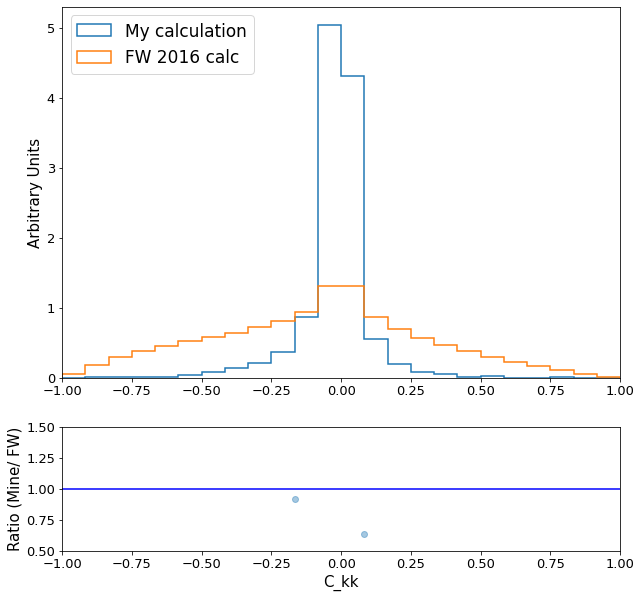

In [34]:
x_low    =  -1
x_high   =   1

binning = np.linspace(x_low,x_high, 25)

fig_style = {
    'figsize': (10, 10),
}

ratio_fig_style = {
    'figsize': (10, 10),
    'gridspec_kw': {'height_ratios': (3, 1)},
}


fig, (ax1, ax2) = plt.subplots(nrows=2, **ratio_fig_style)
ns1, bins1, patches  = ax1.hist(h_cnn , density=True, histtype='step', bins=binning, label='My calculation', linewidth=1.5)
ns2, bins2, patches  = ax1.hist(tt_cnn, density=True, histtype='step', bins=binning, label='FW 2016 calc', linewidth=1.5)

ax1.legend(prop={'size': 17}, loc='upper left')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],     # this is what makes it comparable
        ns1 / ns2,         # maybe check for div-by-zero!
        alpha=0.4)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Ratio (Mine/ FW)', fontsize=15)
ax2.set_xlabel('C_kk', fontsize=15)
ax2.set_ylim(0.5,1.5)
ax2.set_xlim(x_low,x_high)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
plt.axhline(y=1, color='b', linestyle='-')
plt.show()

In [100]:
file_2016['top_arapidity'].array()

array([1.3988022 , 0.48214915, 1.4091815 , ..., 0.6827246 , 0.4714828 ,
       0.47794238], dtype=float32)

In [30]:
np.savetxt('ttbar_ellipse_reco_exact_sol_only.txt' , tt_mass)
np.savetxt('ttbar_ellipse_reco_exact_selection.txt', selection)

In [11]:
tt_gen_mass = np.loadtxt('ttbar_final_gen_mass.txt')

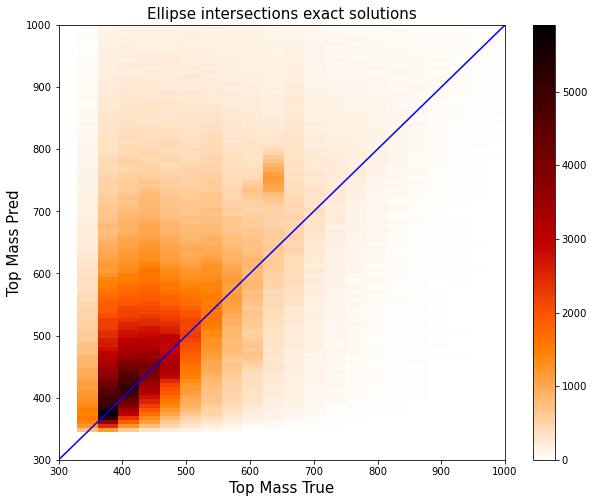

In [185]:
tt_gen_red = tt_gen_mass[selection == 1]
mask       = tt_mass < 1000
tt_gen_sel = tt_gen_red[mask]

heatmap,xedges,yedges = np.histogram2d(tt_gen_sel ,tt_mass[tt_mass < 1000], bins=100)
extent                = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10,8))
plt.imshow(heatmap.T ,extent=extent, origin='lower', aspect='auto')
plt.plot([0,1000],[0,1000],color='blue')
plt.set_cmap('gist_heat_r')
plt.xlabel("Top Mass True", fontsize=15)
plt.ylabel("Top Mass Pred", fontsize=15)
plt.title("Ellipse intersections exact solutions", fontsize=15)
plt.xlim(300,1000)
plt.ylim(300,1000)
plt.colorbar()
#plt.savefig('ellipse_int_heatmap_min_mass.jpg')

In [14]:
file_2016 = uproot.open('emu_steps.root')['ttBar_treeVariables_step8']

In [15]:
m_ttbar     = file_2016['ttbar_mass'].array()
gen_m_ttbar = file_2016['gen_ttbar_mass'].array()

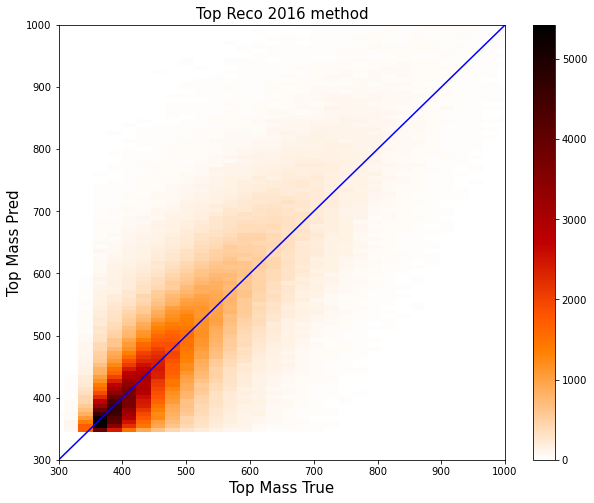

In [184]:
mask    = m_ttbar < 1000
gen_sel = gen_m_ttbar[mask]
heatmap,xedges,yedges =np.histogram2d(gen_sel ,m_ttbar[m_ttbar < 1000],bins=100)
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.figure(figsize=(10,8))
plt.imshow(heatmap.T ,extent=extent, origin='lower', aspect='auto')
plt.plot([0,1000],[0,1000],color='blue')
plt.set_cmap('gist_heat_r')
plt.xlabel("Top Mass True", fontsize=15)
plt.ylabel("Top Mass Pred", fontsize=15)
plt.title("Top Reco 2016 method" , fontsize=15)
plt.xlim(300,1000)
plt.ylim(300,1000)
plt.colorbar()
#plt.savefig('heatmap_2016_technique.jpg')

## PLOTTING UNITS

In [17]:
def multigraph(pred, true, title, lower, upper, bins):
    bins = np.histogram(true, bins=bins)[1]
    bincountsx,binedgesx,binnumx = stats.binned_statistic(pred, pred, statistic='count', bins=bins)
    bincountsy,binedgesy,binnumy = stats.binned_statistic(true, true, statistic='count', bins=bins)
    
    fig,axs = plt.subplots(2, gridspec_kw={'height_ratios':[3,1]}, figsize=(10,10))
    fig.suptitle(title, fontsize=15)
    axs[0].hist(pred, bins=bins, density=1, histtype='step', label = "ttbar mass reco", linewidth=1.5)
    axs[0].hist(true, bins=bins, density=1, histtype='step', label = "ttbar mass gen ", linewidth=1.5)
    axs[0].set_ylabel("AU", fontsize=15)
    axs[0].set_xlabel("ttbar mass", fontsize=15)
    axs[0].legend(fontsize=15)
    axs[0].set_xlim([lower,upper])

    axs[0].tick_params(axis='x', labelsize=13)
    axs[0].tick_params(axis='y', labelsize=13)
    
    binratio   = bincountsx/bincountsy
    bincenters = (bins[1:]+bins[:-1])/2
    bincentersfinal = bincenters[binratio!=0]
    
    biniszero =  binratio==0
    binratio  =  binratio[binratio!=0]
    binisnan  =  np.isnan(binratio)
    binnonan  =~ binisnan
    
    axs[1].scatter(bincentersfinal[binnonan],binratio[binnonan])
    axs[1].scatter(bincentersfinal[binisnan],np.ones(len(bincentersfinal[binisnan])),marker='x',color='red')
    axs[1].scatter(bincenters[biniszero],np.ones(len(bincenters[biniszero])),marker='x',color='blue')
    axs[1].axhline(y=1)
    axs[1].set_xlim([lower,upper])
    axs[1].set_ylim([0.5,1.5])

    axs[1].tick_params(axis='x', labelsize=13)
    axs[1].tick_params(axis='y', labelsize=13)
    
    _,pval=stats.ks_2samp(true,pred)
    #axs[1].set_xlabel("P-value: %.2e" % pval)
    #fig.savefig("Plots/%s_plots.jpg" % title,bbox_inches='tight')

In [18]:
for i in range(len(tt_mass)):
    if i==3 or i==7:
        bins=100
        lower=-1
        upper=5
    elif i==11 or i==15:
        bins=20
        lower=-1.5
        upper=4
    else:
        bins=50
        lower=-6
        upper=6

In [19]:
def cuts(datain, datacheck, minval, maxval):
    dataout = datain[np.logical_and(datacheck>minval,datacheck<maxval)]
    return(dataout)

def sem(values):
    sem     = stats.sem(values)
    return(sem)

def plotgaussian(resids,title):
    from matplotlib.pyplot import figure
    figure(figsize=(8, 6))
    resids.sort()
    resmean = np.mean(resids)
    resstd  = np.std(resids)
    pdf     = stats.norm.pdf(resids,resmean,resstd)
    
    plt.hist(resids,bins=50,histtype='step',color='blue',density=1,label='Residuals')
    plt.plot(resids,pdf,label="Normal Curve",color='black')
    plt.title(title)
    plt.xlim(-600,600)
    plt.axvline(resmean, label="Mean: %.2f" % resmean, color='red') 
    
    fwhm    = 2*np.sqrt(2*np.log(2))*resstd
    samples = len(resids)
    
    plt.xlabel("FWHM: %.2f (samples: %.i)" % (fwhm,samples))
    #plt.axvspan(resmean-fwhm/2,resmean+fwhm/2,facecolor='g',alpha=.5,label='FWHM')
    plt.legend()

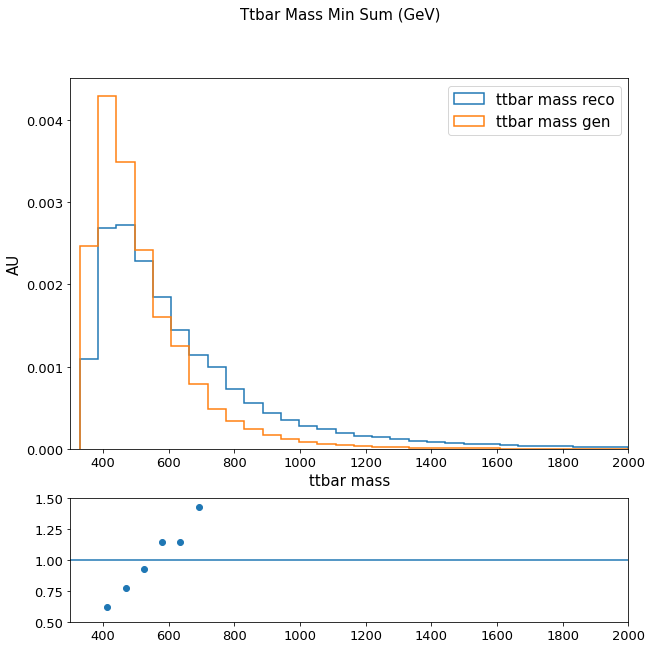

In [41]:
tt_mass    = np.array(tt_mass)
tt_gen_red = np.array(tt_gen_red)
multigraph(tt_mass[tt_mass < 2000], tt_gen_red[tt_gen_red < 2000], "Ttbar Mass Min Sum (GeV)" ,300, 2000, 30)

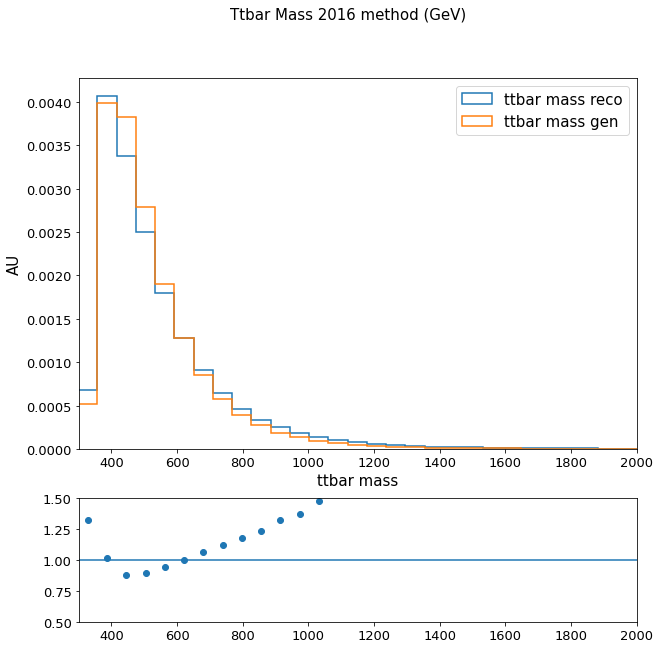

In [42]:
m_ttbar     = np.array(m_ttbar)
gen_m_ttbar = np.array(gen_m_ttbar)
multigraph(m_ttbar[m_ttbar < 2000], gen_m_ttbar[gen_m_ttbar < 2000], "Ttbar Mass 2016 method (GeV)" ,300, 2000, 30)

In [17]:
len(top_pt)

7360

In [19]:
len(tt_l_pt[selection == 1])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1507877 but corresponding boolean dimension is 10000

In [ ]:
'''
l_pt   = file_2016['l_pt'].array()
l_eta  = file_2016['l_eta'].array()
l_phi  = file_2016['l_phi'].array()

t_pt   = file_2016['top_pt'].array()
t_eta  = file_2016['top_rapidity'].array()
t_phi  = file_2016['top_phi'].array()

lbar_pt   = file_2016['lbar_pt'].array()
lbar_eta  = file_2016['lbar_eta'].array()
lbar_phi  = file_2016['lbar_phi'].array()

tbar_pt   = file_2016['tbar_pt'].array()
tbar_eta  = file_2016['tbar_rapidity'].array()
tbar_phi  = file_2016['tbar_phi'].array()
'''